## Vector Autoregression - VARX

In [2]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from sklearn import metrics
from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format

### Import the datasets

In [34]:
data = pd.read_csv('train.csv')
print(data.shape)  # (421570, 5)

data['Date'] = pd.to_datetime(data['Date'])

display(data.info())
data.head(20)

(421570, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


None

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False


In [35]:
exog = data.groupby('Date')['IsHoliday'].sum() > 0

exog = exog.apply(lambda x: float(x))

exog.head()

Date
2010-02-05   0.00
2010-02-12   1.00
2010-02-19   0.00
2010-02-26   0.00
2010-03-05   0.00
Name: IsHoliday, dtype: float64

In [36]:
data = data.pivot_table(index='Date', columns='Store', values='Weekly_Sales')

data.head()

Store,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,22516.31,29273.83,7101.88,29248.55,5115.70,22638.84,6898.96,14552.71,8862.99,29240.65,21222.34,15714.95,26229.61,36950.28,9451.05,7344.76,11271.94,17989.66,20939.41,32895.83,12099.91,15418.17,18954.47,19287.86,10107.93,14987.23,26775.57,23227.12,8161.13,8944.39,20126.74,15105.78,6864.84,12922.01,18367.37,12303.86,10938.91,7029.34,18097.01,14520.92,15303.28,11812.70,13479.78,5856.06,13293.87
2010-02-12,22804.96,29691.80,6573.89,29177.43,4797.32,22003.89,7487.21,14011.29,8772.66,29405.79,22495.49,16439.17,26722.81,23669.71,9611.93,7152.19,12027.88,17468.83,21340.97,29705.75,12079.42,14819.87,19727.03,19109.56,8454.55,14936.53,24241.15,21652.34,7905.57,10150.50,21745.74,15824.87,7372.07,14008.61,17445.00,12690.91,11038.60,6844.30,17834.21,13647.69,15150.09,12249.15,14846.07,5976.19,9661.60
2010-02-19,22081.76,29102.08,6486.80,28080.28,4668.42,21765.81,7137.47,13770.86,7866.58,28179.10,21173.22,15428.47,26270.33,30618.84,9577.37,7341.70,11277.66,16438.05,20213.01,29610.27,12944.53,14120.97,18585.75,19241.15,9800.88,14276.41,27395.36,20712.51,8095.51,9459.45,20751.93,15035.54,6903.51,13296.80,18965.05,12375.82,10632.97,6544.76,17834.67,13089.85,15029.07,10383.57,13729.12,5582.42,12192.23
2010-02-26,19579.55,25549.28,6463.57,26023.36,4158.18,19629.50,6987.09,12283.94,7402.71,26404.93,18822.60,15420.84,24565.54,29105.44,7956.10,6925.66,10863.04,15480.54,19618.14,26363.80,11532.27,13231.79,16883.23,16553.18,8978.81,12396.88,19053.89,22031.05,7514.12,9083.28,19205.06,14834.47,6928.12,12757.13,15464.42,11474.86,10481.96,6962.97,17185.03,12167.85,13588.24,10685.01,12889.64,5810.19,10598.45
2010-03-05,21298.72,27274.15,6590.51,27375.80,4513.37,21936.29,6921.40,12415.55,8052.35,26494.53,20380.32,15385.98,26215.95,31077.01,8772.83,7050.51,11691.05,17349.10,21068.23,29030.32,10991.83,14841.19,19002.55,19616.49,9790.44,14574.92,18767.57,22339.38,8360.75,9451.82,19505.22,15022.07,7287.12,12579.39,17615.31,12636.93,10385.11,7596.73,18089.35,13945.81,14979.68,12064.62,14317.39,5692.35,11611.21


### Visualize the Time Series

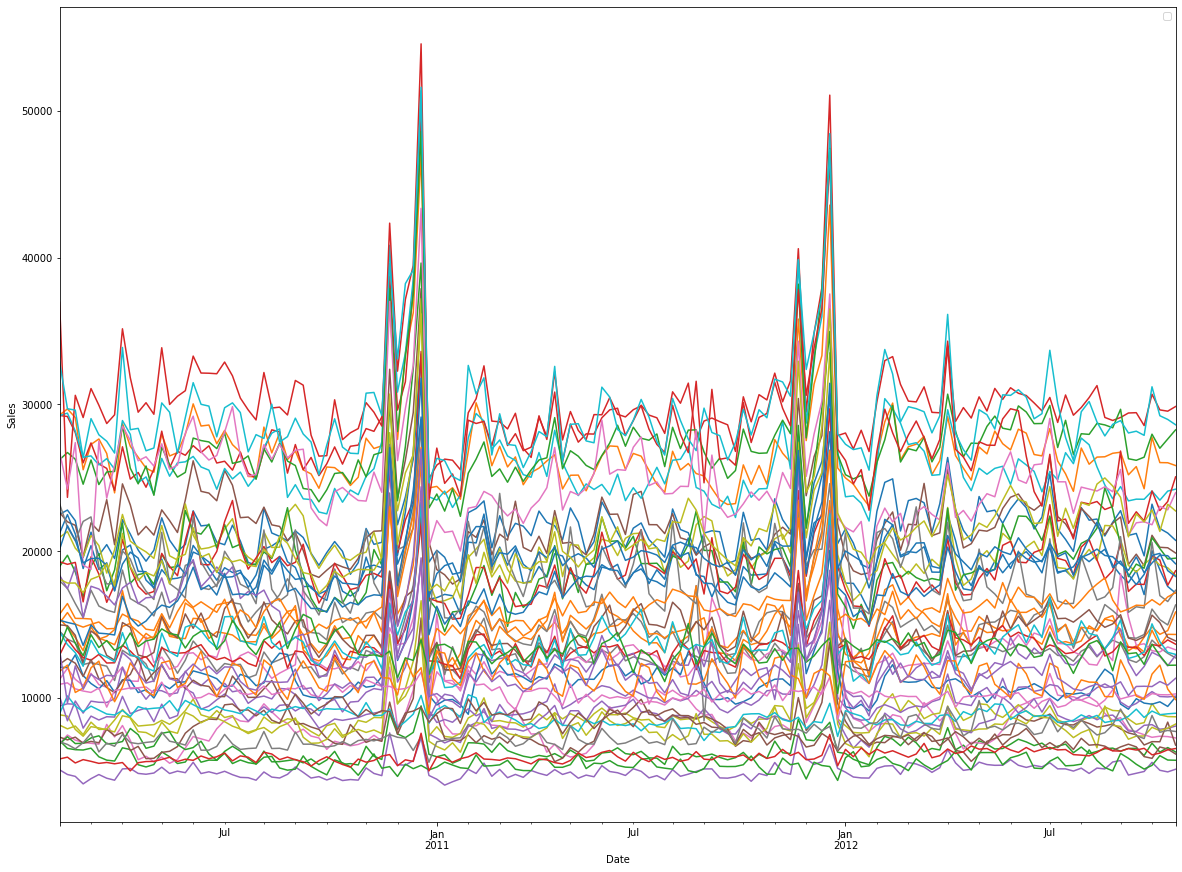

In [37]:
ax = data.plot(figsize=(20,15))
ax.legend([])
ax.set_ylabel('Sales')
plt.show()

In [45]:
train = data.iloc[:-10,[0,1,2]]
test = data.iloc[-10:,[0,1,2]]

display(train.info())
display(train.head())

display(test.info())
display(test.head())

train_exog = exog[:-10]
test_exog = exog[-10:]

display(test_exog.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 2010-02-05 to 2012-08-17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       133 non-null    float64
 1   2       133 non-null    float64
 2   3       133 non-null    float64
dtypes: float64(3)
memory usage: 4.2 KB


None

Store,1,2,3
Date,,,
2010-02-05,22516.31,29273.83,7101.88
2010-02-12,22804.96,29691.80,6573.89
2010-02-19,22081.76,29102.08,6486.80
2010-02-26,19579.55,25549.28,6463.57
2010-03-05,21298.72,27274.15,6590.51


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2012-08-24 to 2012-10-26
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       10 non-null     float64
 1   2       10 non-null     float64
 2   3       10 non-null     float64
dtypes: float64(3)
memory usage: 320.0 bytes


None

Store,1,2,3
Date,,,
2012-08-24,21043.98,26433.64,6546.82
2012-08-31,21973.38,26672.37,6594.17
2012-09-07,22763.94,26743.34,6378.59
2012-09-14,21075.40,25205.65,6574.02
2012-09-21,21213.04,25766.42,6577.65


Date
2012-08-24   0.00
2012-08-31   0.00
2012-09-07   1.00
2012-09-14   0.00
2012-09-21   0.00
Name: IsHoliday, dtype: float64

In [46]:
mod = sm.tsa.VARMAX(train, order=(1,1), exog=train_exog)
res = mod.fit(maxiter=100, disp=False)

In [47]:
fcst = res.forecast(exog=test_exog.values, steps=10)
display(fcst.info())

#test = test.index.freq = 'W-FRI'

display(test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2012-08-24 to 2012-10-26
Freq: W-FRI
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       10 non-null     float64
 1   2       10 non-null     float64
 2   3       10 non-null     float64
dtypes: float64(3)
memory usage: 320.0 bytes


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2012-08-24 to 2012-10-26
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       10 non-null     float64
 1   2       10 non-null     float64
 2   3       10 non-null     float64
dtypes: float64(3)
memory usage: 320.0 bytes


None

In [48]:
mape = metrics.mean_absolute_percentage_error(test,fcst)
model_accuracy = 1 - mape
print(model_accuracy)

0.9620677387054917


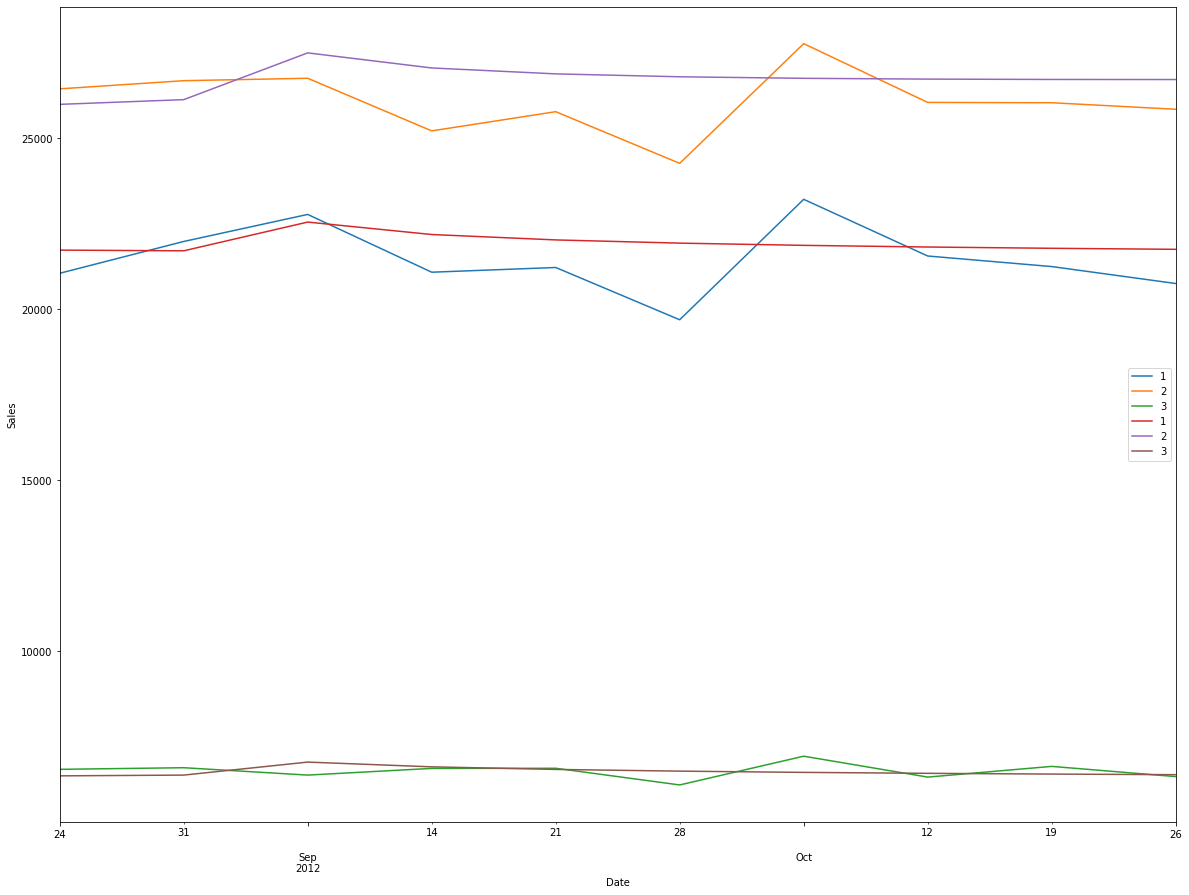

In [49]:
ax = test.plot(figsize=(20,15))
fcst.plot(ax=ax)
ax.legend()
ax.set_ylabel('Sales')
plt.show()